In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerNN
from models import KerasSimpleOnlineRNN, KerasOnlineGRU
from sklearn import metrics

Using TensorFlow backend.


Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


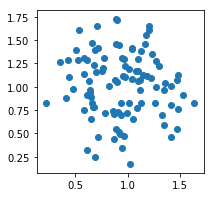

In [2]:
def build_2d_data(N, beta=0.1):
    """ 
    2d, Mulitvariate Guassian data
    """
    mu = [1, 1]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        x[n, :] = np.random.multivariate_normal(mu, Sigma)
        
    return x
X = build_2d_data(100)
plt.figure(figsize=(3,3))
plt.scatter(X[:,0], X[:, 1])

In [3]:
D = 2
X_train = X[0:-1]; y_train = X[1:]

Now, we define some toy problem

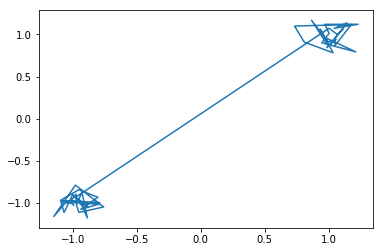

In [4]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.eye(2) * beta)
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.eye(2) * beta)
        
    return x

x_train = build_static_dataset(50, 0.01)
y = np.concatenate([np.zeros((25), dtype=int), np.ones((25), dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

In [5]:
# SEM parameters
K = 20  # maximum number of event types
lmda = 10  # stickyness parameter
alfa = 1.00  # concentration parameter
beta = 0.1 # transition noise
eta =  0.1  # learning rate


# define plotting function
import seaborn as sns

def plot_segmentation(post, y):
    cluster_id = np.argmax(post, axis=1)
    cc = sns.color_palette('Dark2', post.shape[1])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        axes[0].scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt], alpha=.5)
        
    axes[1].plot(post)
    y_hat = np.argmax(post, axis=1)
    print "Adjusted Mutual Information:", metrics.adjusted_mutual_info_score(y, y_hat)
    print "Adjusted Rand Score:", metrics.adjusted_rand_score(y, y_hat)
    print 
    print np.argmax(post, axis=1)

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.0209537920185
Adjusted Rand Score: -0.00125037017538

[0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 4 0 3 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


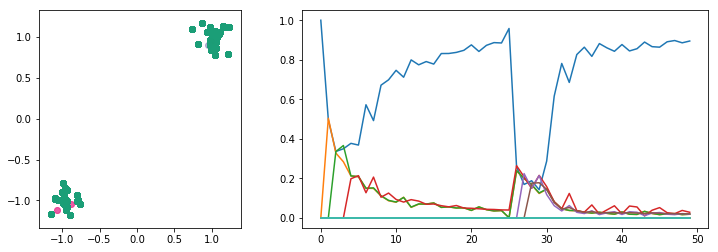

In [6]:
sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '



Adjusted Mutual Information: 0.127053664509
Adjusted Rand Score: 0.328902982054

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 11 12  4  4  4
 15 14 10 15  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]


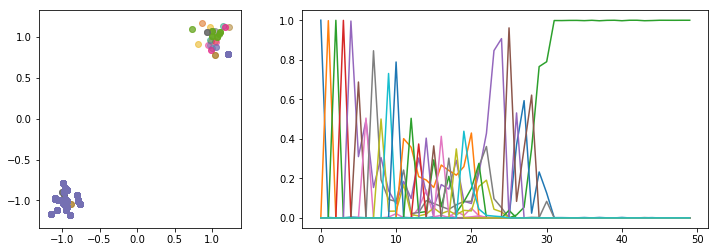

In [7]:
# Initialize keras model
sem_kwargs2 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasLDS, f_opts=dict())

sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.186176941749
Adjusted Rand Score: 0.285820567448

[ 0  1  2  1  0  3  4  5  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  2  7  8  9 10 11 12 13 10 14 15 16 17 18 19 18 12  8 11 10 10 10 10 10 10]


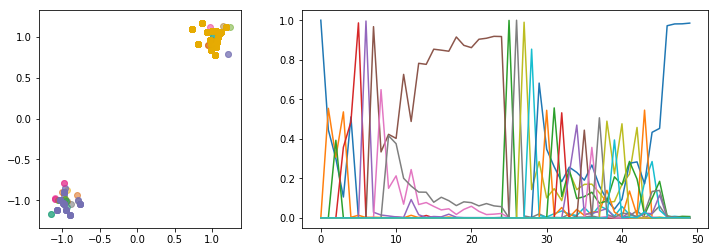

In [8]:
# Initialize keras model
sem_kwargs3 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasMultiLayerNN, f_opts=dict())

sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


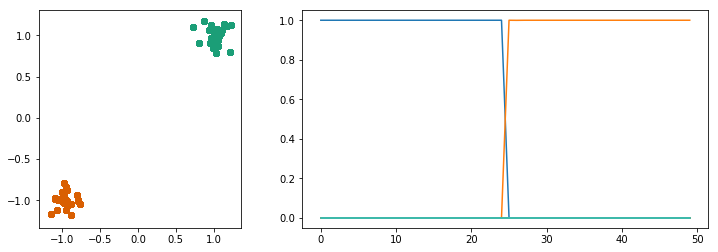

In [9]:
# Initialize keras model
sem_kwargs4 = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=KerasSimpleOnlineRNN, f_opts=dict(t=5))

sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Alternating between 2 static events


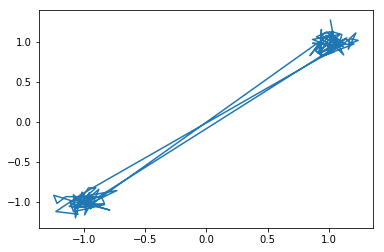

In [10]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), np.zeros(25, dtype=int), np.ones(25, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.0113549091075
Adjusted Rand Score: 0.00283273508666

[0 1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


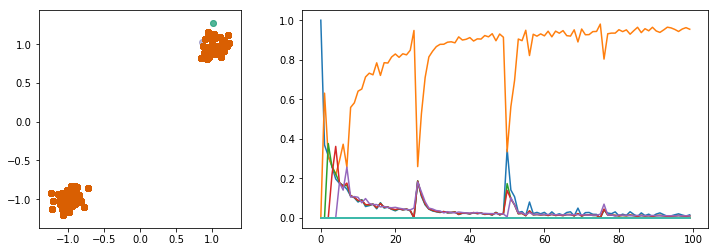

In [11]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.367327153734
Adjusted Rand Score: 0.642722256586

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 11 11 11 11 11 11 11 11 11 11 11
 12 14 15 16 17 18 19 14 15 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14]


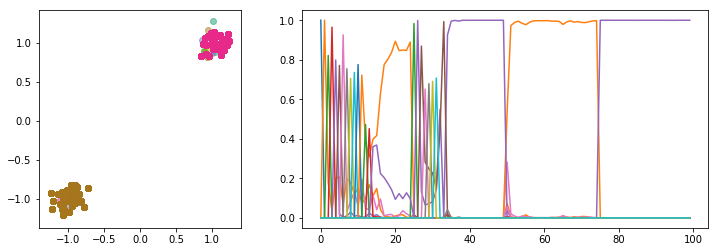

In [12]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.510426046499
Adjusted Rand Score: 0.757859088567

[ 0  1  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  4  5  6  7  8  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  6 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


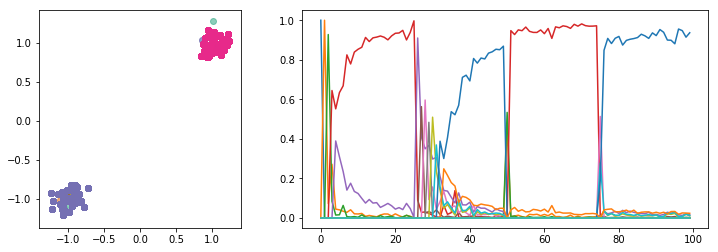

In [13]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


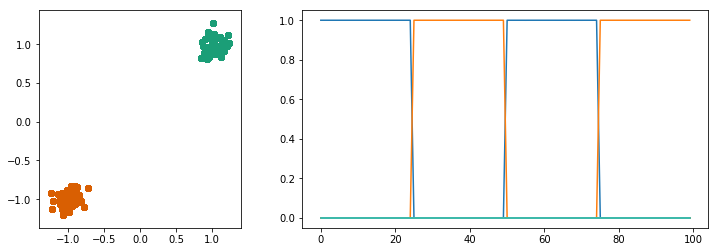

In [14]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# Example of four events where the events correspond to movement in vector space

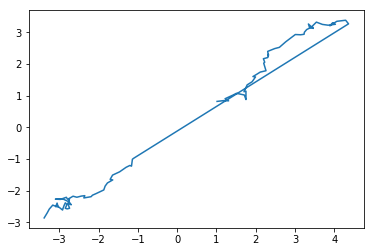

In [15]:
def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
y = np.concatenate([np.zeros(50, dtype=int), np.ones(50, dtype=int)])
plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.00635097013416
Adjusted Rand Score: 0.0145958766648

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 2 3 4 5 6 7 8 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


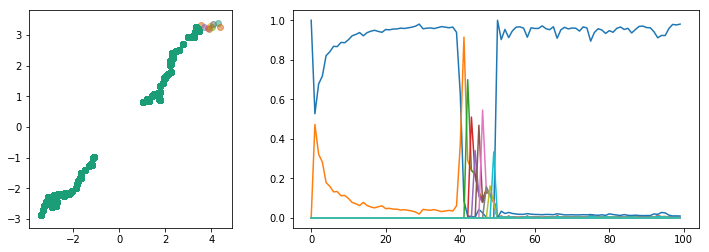

In [16]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.318288421133
Adjusted Rand Score: 0.580988007391

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  8 12  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 12 12 12 12 12 12 14 14
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]


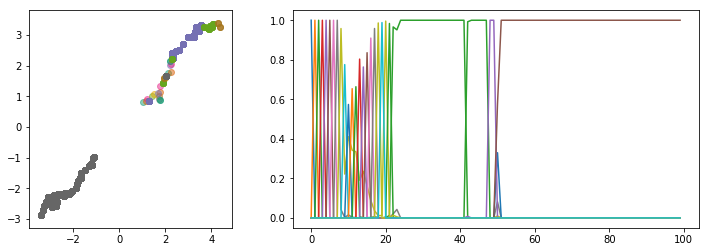

In [17]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.0876199557387
Adjusted Rand Score: 0.164603005475

[ 0  1  2  3  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 14 14 14 14 14 14 14 14 14 14
  0  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5]


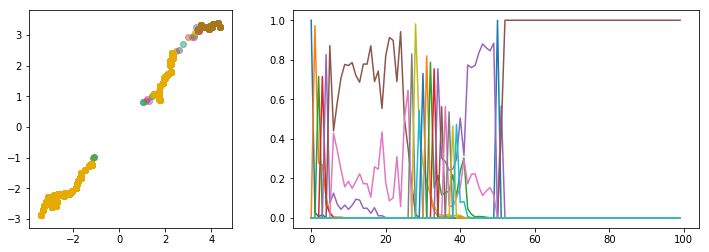

In [18]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 1.0
Adjusted Rand Score: 1.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


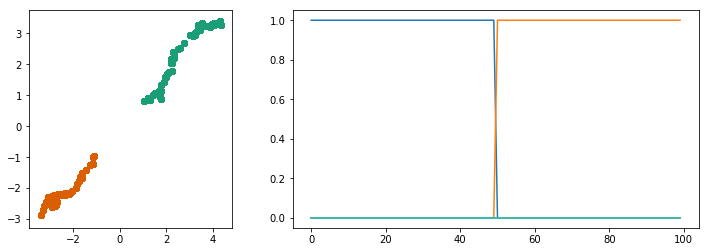

In [19]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

# 4 events where the events correspond to movement in vector space


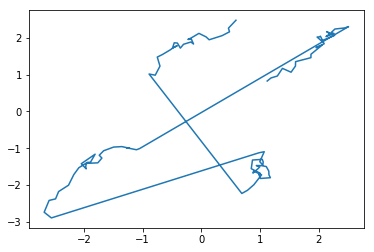

In [20]:
def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
y = np.concatenate([np.zeros(25, dtype=int), np.ones(25, dtype=int), 
                    np.ones(25, dtype=int)*2, np.ones(25, dtype=int)*3])

plt.plot(x_train[:, 0], x_train[:, 1])

### Linear dynamical solution (analytic)


Adjusted Mutual Information: 0.422782960738
Adjusted Rand Score: 0.437863724539

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  0  1  0  1  0  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  0  0  2  3  4  5  6  7  6  8  9  6 10 11  6 12 13 11 14 15 11 11 11 11]


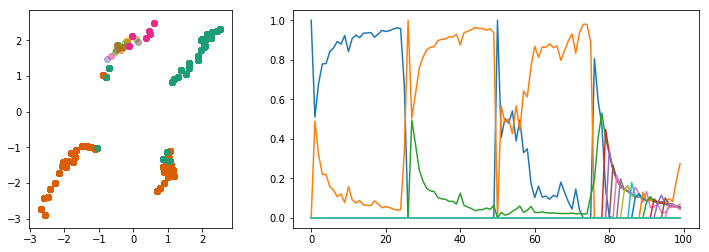

In [21]:
sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)
plot_segmentation(post, y)

### Linear dynamical system (Keras estimate)


Adjusted Mutual Information: 0.506982301325
Adjusted Rand Score: 0.713427651337

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 10 10 10 10 10
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
 14  6  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
 14  0  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3]


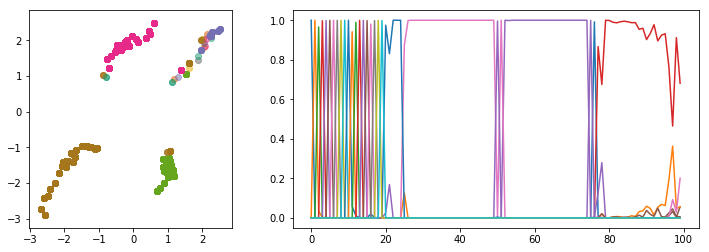

In [22]:
sem2 = SEM(**sem_kwargs2)
post = sem2.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Multilayer NN with nonlinear hidden layer


Adjusted Mutual Information: 0.475755445878
Adjusted Rand Score: 0.52082616179

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 14 14 14 14 14 14 15 16 15 17
  7 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
  8 19 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18]


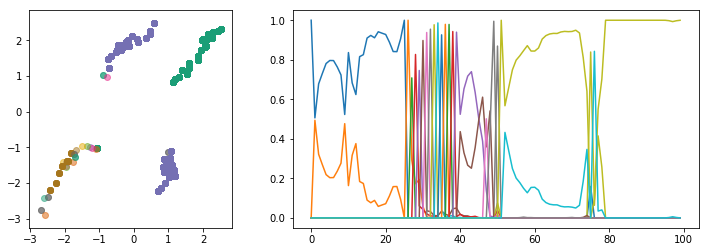

In [23]:
sem3 = SEM(**sem_kwargs3)
post = sem3.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)

### Recurrent, Multilayer NN 


Adjusted Mutual Information: 0.969288171226
Adjusted Rand Score: 0.986709625453

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


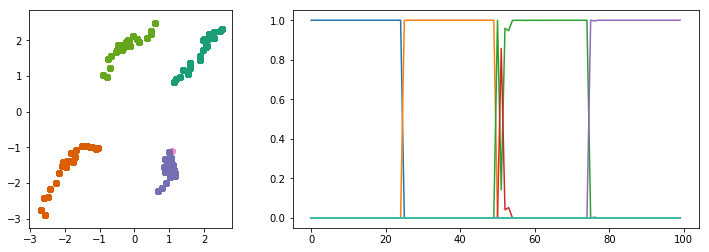

In [24]:
sem4 = SEM(**sem_kwargs4)
post = sem4.run(x_train, K=K)
tf.Session().close()
plot_segmentation(post, y)